In [9]:
import matplotlib.pyplot as plt
from glob import glob
from deepforest import main
import cv2
import os
from PIL import Image
import numpy as np

In [3]:
forest = 'forest1'

In [4]:
vidcap = cv2.VideoCapture('./{}/forest.mp4'.format(forest))

success,image = vidcap.read()
count = 0
if not os.path.exists('./{}/frames'.format(forest)):
  os.mkdir('./{}/frames'.format(forest))
  while success:
    cv2.imwrite("./{}/frames/frame{}.jpg".format(forest, count), image)     # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1

In [5]:
stitcher = cv2.Stitcher_create()

if not os.path.exists('./{}/stitch.jpg'.format(forest)):
    images = []
    for filename in os.listdir('./{}/frames'):
        img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        
        scale_percent = 60 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        images.append(cv2.resize(img, dim)) 
    result = stitcher.stitch(images)
    print(result[0])

    cv2.imwrite('./{}/stitch.jpg'.format(forest), result[1])

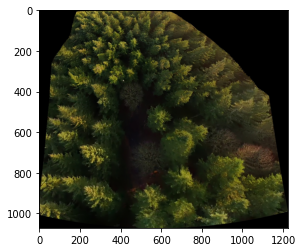

In [6]:
result = cv2.imread("./{}/stitch.jpg".format(forest))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

Reading config file: /usr/local/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/usr/local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


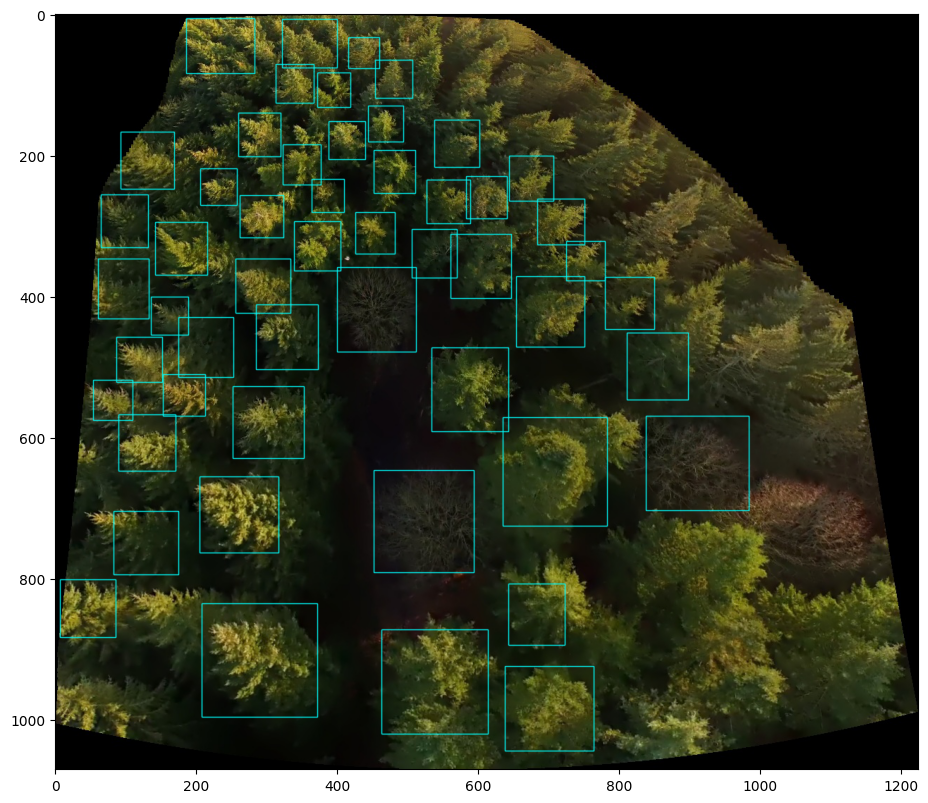

In [7]:
model = main.deepforest()
model.use_release()

plt.figure(figsize=(15, 10), dpi=100)
img = model.predict_image(path="./{}/stitch.jpg".format(forest), return_plot=True)
frame = model.predict_image(path="./{}/stitch.jpg".format(forest))

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order.
plt.imshow(img[:,:,::-1])
plt.show()

In [8]:
inchesPerPixel = 0.075
heightInInches = 15 

total_lbs = 0
for i, row in frame.iterrows():
    diameter = min(row['xmax'] - row['xmin'], row['ymax'] - row['ymin']) * inchesPerPixel
    weight = 0.25 * pow(diameter, 2) * heightInInches
    green_weight = weight * 1.20
    dry_weight = green_weight * 0.725
    lbs_carbon = dry_weight * 0.50
    lbs_co2 = lbs_carbon * 3.6663
    lbs_co2_per_year = lbs_co2 / 10
    total_lbs = total_lbs + lbs_co2_per_year
total_tons = total_lbs / 2204.62
print("Metric tons per year of CO2 sequestered per year", total_tons)
print("Total tax credits for trees in video per year", "$" + str(round(total_tons * 50, 2)))

Metric tons per year of CO2 sequestered per year 0.5456835850349033
Total tax credits for trees in video per year $27.28


In [153]:
def getDisparityBetweenFrames(path1, path2):
    imgL = cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2RGB)
    imgR = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2RGB)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY)
    plt.imshow(grayL, 'gray')

    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
    return stereo.compute(grayL, grayR)

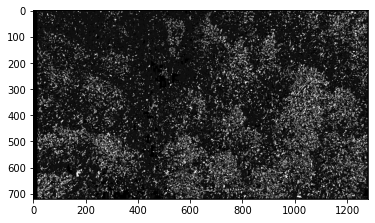

In [154]:

plt.imshow(getDisparityBetweenFrames("./{}/frames/frame0.jpg".format(forest), "./{}/frames/frame1.jpg".format(forest)),'gray')
plt.show()

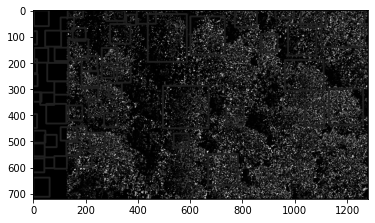

In [145]:
frame = model.predict_image(path="./{}/frames/frame0.jpg".format(forest))

for index, row in frame.iterrows():
    if row.label == "Tree":
        disparity = cv2.rectangle(disparity, (int(row.xmin), int(row.ymin)), (int(row.xmax), int(row.ymax)), color=(255, 255, 255), thickness=5)

plt.imshow(disparity, 'gray')

In [158]:
def get_average_height_of_frame(frame, disparity):
    heights = np.array([])
    for _, row in frame.iterrows():
        if row.label == "Tree":
            tree_section = disparity[int(row.xmin):int(row.xmax), int(row.ymin):int(row.ymax)]
            if (len(tree_section) > 0):
                max_height = np.unravel_index(np.argmax(tree_section), tree_section.shape)
                heights = np.append(heights, max_height)
    return np.mean(heights)

In [159]:
get_average_height_of_frame(frame, disparity)

23.760416666666668

127.5 1.2857142857142858


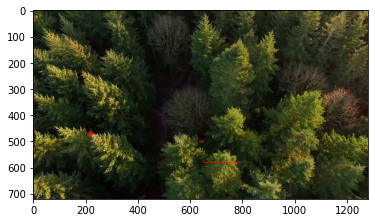

In [201]:
calibration_point = (220, 470) # should be set through a gui
calibration_line = [np.array((650, 580)), np.array((790, 580))]
calibration_height = 2040 # in inches 
calibration_length = 180
calibration_image = cv2.cvtColor(cv2.imread('./{}/frames/frame0.jpg'.format(forest)), cv2.COLOR_BGR2RGB)
calibration_image = cv2.circle(calibration_image, calibration_point, 5, color=(255, 0, 0), thickness=5)
calibration_image = cv2.line(calibration_image, calibration_line[0], calibration_line[1], color=(255,0,0), thickness=2)
calibration_ratio = np.abs(calibration_height / disparity[calibration_point])
distance_per_pixel = 180 / np.linalg.norm(calibration_line[0] - calibration_line[1])
print(calibration_ratio, distance_per_pixel)
plt.imshow(calibration_image)

In [200]:
def convert_disparity_value_to_inches(disparity_value, calibration_ratio):
    return disparity_value * calibration_ratio

In [168]:
def get_average_height_of_tree(calibration_ratio):
    heights = []
    number_of_frames = len(os.listdir('./{}/frames'.format(forest)))
    for i in range(0, number_of_frames, 10):
        frameA = "./{}/frames/frame{}.jpg".format(forest, i)
        frameB = "./{}/frames/frame{}.jpg".format(forest, i + 1)
        treeFrame = model.predict_image(path=frameA)
        disparity = getDisparityBetweenFrames(frameA, frameB)
        average_frame_height = get_average_height_of_frame(treeFrame, disparity)
        height_in_inches = convert_disparity_value_to_inches(average_frame_height, calibration_ratio)
        print("Average height for frame {} is {}in".format(i, height_in_inches))
        heights = np.append(heights, height_in_inches)
        
    return np.mean(heights)


Average height for frame 0 is 1846.09375in
Average height for frame 10 is 2191.9148936170213in
Average height for frame 20 is 2249.266304347826in
Average height for frame 30 is 2608.4375in
Average height for frame 40 is 2130.666666666667in
Average height for frame 50 is 2195.833333333333in
Average height for frame 60 is 2131.640625in
Average height for frame 70 is 2188.75in
Average height for frame 80 is 2155.2925531914893in
Average height for frame 90 is 1990.1086956521738in
Average height for frame 100 is 1954.575in
Average height for frame 110 is 2301.5051020408164in
Average height for frame 120 is 1991.8622448979593in
Average height for frame 130 is 2478.4438775510203in
Average height for frame 140 is 2538.525in
Average height for frame 150 is 2285.703125in
Average height for frame 160 is 2688.975in
Average height for frame 170 is 2189.6173469387754in
Average height for frame 180 is 2468.984375in
Average height for frame 190 is 2303.3152173913045in
Average height for frame 200 is 2

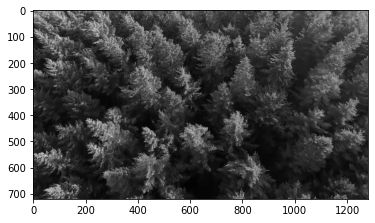

In [171]:
average_height = get_average_height_of_tree(calibration_ratio)

In [208]:

def print_summary(average_tree_height_in_inches, distance_per_pixel, stitched_tree_frame):
    tree_trunk_ratio = 0.0625
    total_lbs = 0
    for _, row in stitched_tree_frame.iterrows():
        diameter = min(row['xmax'] - row['xmin'], row['ymax'] - row['ymin']) * tree_trunk_ratio * distance_per_pixel 
        weight = 0.25 * pow(diameter, 2) * (average_tree_height_in_inches / 12)
        green_weight = weight * 1.20
        dry_weight = green_weight * 0.725
        lbs_carbon = dry_weight * 0.50
        lbs_co2 = lbs_carbon * 3.6663
        lbs_co2_per_year = lbs_co2 / 10
        total_lbs = total_lbs + lbs_co2_per_year
    total_tons = total_lbs / 2204.62
    print("Metric tons per year of CO2 sequestered per year", total_tons)
    print("Total tax credits for trees in video per year", "$" + str(round(total_tons * 50, 2)))

In [209]:
print_summary(average_height, distance_per_pixel, frame)

Metric tons per year of CO2 sequestered per year 5.812534690466642
Total tax credits for trees in video per year $290.63


In [46]:
import matplotlib.pyplot as plt
from glob import glob
from deepforest import main
import cv2
import os
from PIL import Image
import numpy as np

def calculate_CO2_sequestered_in_video(path_to_video_directory, calibration_parameters):
    model = main.deepforest()
    model.use_release()
    write_frames_to_dir(path_to_video_directory)
    stitch_path = stitch_frames(path_to_video_directory)
    stitch_data_frame = get_stitch_frame(stitch_path, model)
    calibration_ratio, distance_per_pixel = calibrate(path_to_video_directory, calibration_parameters)
    average_height = get_average_height_of_tree(path_to_video_directory, calibration_ratio, model)
    print_summary(average_height, distance_per_pixel, stitch_data_frame)
    plt.imshow(cv2.cvtColor(cv2.imread(stitch_path), cv2.COLOR_BGR2RGB))
    

def write_frames_to_dir(video_directory):
    vidcap = cv2.VideoCapture('{}/forest.mp4'.format(video_directory))
    frames_path = '{}/frames'.format(video_directory)

    success,image = vidcap.read()
    count = 0
    if not os.path.exists(frames_path):
        os.mkdir(frames_path)
        while success:
            cv2.imwrite("{}/frame{}.jpg".format(frames_path, count), image)     # save frame as JPEG file      
            success,image = vidcap.read()
            count += 1

def stitch_frames(video_path):
    stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)
    stitch_path = '{}/stitch.jpg'.format(video_path)

    if not os.path.exists(stitch_path):
        images = []
        filenames = get_frames_in_order(video_path)
        for i in range(0, len(filenames), 10): 
            filename = filenames[i]
            img = cv2.imread('{}/frames/{}'.format(video_path, filename), cv2.IMREAD_UNCHANGED)
            
            scale_percent = 100 # percent of original size
            width = int(img.shape[1] * scale_percent / 100)
            height = int(img.shape[0] * scale_percent / 100)
            dim = (width, height)
            images.append(cv2.resize(img, dim)) 
        result = stitcher.stitch(images)

        cv2.imwrite(stitch_path, result[1])
    return stitch_path

def get_frames_in_order(video_path):
    filenames = os.listdir('{}/frames'.format(video_path))
    frameIds = [int(x.replace("frame", "").replace(".jpg", "")) for x in filenames]
    frameIds.sort()
    return ["frame{}.jpg".format(x) for x in frameIds] 

def get_stitch_frame(stitch_path, model):
    return model.predict_image(path=stitch_path)

def calibrate(video_path, calibration_parameters):
    disparity = get_disparity_between_frames('{}/frames/frame0.jpg'.format(video_path), '{}/frames/frame1.jpg'.format(video_path)) 
    calibration_point, calibration_line, calibration_height, calibration_length = calibration_parameters
    calibration_ratio = np.abs(calibration_height / disparity[calibration_point])
    distance_per_pixel = calibration_length / np.linalg.norm(calibration_line[0] - calibration_line[1])
    return (calibration_ratio, distance_per_pixel)
    
def get_average_height_of_tree(video_directory, calibration_ratio, model):
    heights = []
    number_of_frames = len(os.listdir('{}/frames'.format(video_directory)))
    for i in range(0, number_of_frames, 10):
        frameA = "{}/frames/frame{}.jpg".format(video_directory, i)
        frameB = "{}/frames/frame{}.jpg".format(video_directory, i + 1)
        treeFrame = model.predict_image(path=frameA)
        disparity = get_disparity_between_frames(frameA, frameB)
        average_frame_height = get_average_height_of_frame(treeFrame, disparity)
        height_in_inches = convert_disparity_value_to_inches(average_frame_height, calibration_ratio)
        heights = np.append(heights, height_in_inches)
    return np.mean(heights)

def get_disparity_between_frames(path1, path2):
    imgL = cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2RGB)
    imgR = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2RGB)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY)
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
    return stereo.compute(grayL, grayR)

def get_average_height_of_frame(frame, disparity):
    heights = np.array([])
    for _, row in frame.iterrows():
        if row.label == "Tree":
            tree_section = disparity[int(row.xmin):int(row.xmax), int(row.ymin):int(row.ymax)]
            if (len(tree_section) > 0):
                max_height = np.unravel_index(np.argmax(tree_section), tree_section.shape)
                heights = np.append(heights, max_height)
    return np.mean(heights)
    
def convert_disparity_value_to_inches(disparity_value, calibration_ratio):
    return disparity_value * calibration_ratio

def print_summary(average_tree_height_in_inches, distance_per_pixel, stitched_tree_frame):
    tree_trunk_ratio = 0.0625
    total_lbs = 0
    for _, row in stitched_tree_frame.iterrows():
        diameter = min(row['xmax'] - row['xmin'], row['ymax'] - row['ymin']) * tree_trunk_ratio * distance_per_pixel 
        weight = 0.25 * pow(diameter, 2) * (average_tree_height_in_inches / 12)
        green_weight = weight * 1.20
        dry_weight = green_weight * 0.725
        lbs_carbon = dry_weight * 0.50
        lbs_co2 = lbs_carbon * 3.6663
        lbs_co2_per_year = lbs_co2 / 10
        total_lbs = total_lbs + lbs_co2_per_year
    total_tons = total_lbs / 2204.62
    print("Metric tons per year of CO2 sequestered per year", total_tons)
    print("Total tax credits for trees in video per year", "$" + str(round(total_tons * 50, 2)))

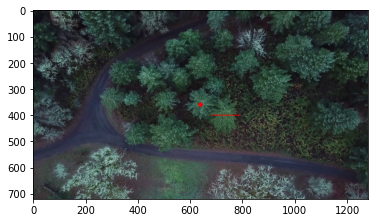

In [47]:

forest = 'forest4'
disparity = get_disparity_between_frames('./{}/frames/frame0.jpg'.format(forest), './{}/frames/frame1.jpg'.format(forest)) 
calibration_point = (640, 360) # should be set through a gui
calibration_line = [np.array((680, 400)), np.array((790, 400))]
calibration_height = 720 # in inches 
calibration_length = 120
calibration_image = cv2.cvtColor(cv2.imread('./{}/frames/frame0.jpg'.format(forest)), cv2.COLOR_BGR2RGB)
calibration_image = cv2.circle(calibration_image, calibration_point, 5, color=(255, 0, 0), thickness=5)
calibration_image = cv2.line(calibration_image, calibration_line[0], calibration_line[1], color=(255,0,0), thickness=2)
plt.imshow(calibration_image)

Reading config file: /usr/local/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0
Metric tons per year of CO2 sequestered per year 2.1765830831919257
Total tax credits for trees in video per year $108.83


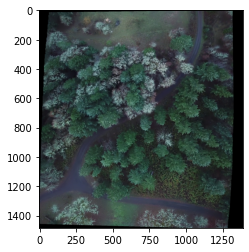

In [48]:
calibration_parameters = (calibration_point, calibration_line, calibration_height, calibration_length)
calculate_CO2_sequestered_in_video('./forest4', calibration_parameters)